In [1]:
import os 
from tqdm.autonotebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

C:\Users\User\AppData\Local\Temp/ipykernel_7476/2199149560.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
data_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
data_dir = './hymenoptera_data'

In [4]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transforms[x])
                 for x in ['train', 'val']}

In [5]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}

In [6]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [7]:
print(dataset_sizes)

{'train': 244, 'val': 153}


In [8]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

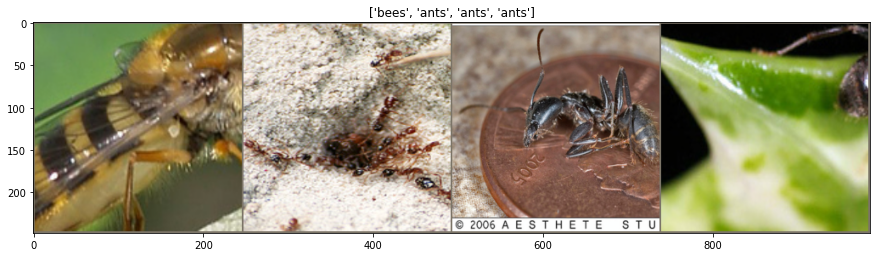

In [9]:
inputs, classes = next(iter(dataloaders['train'])) #получение 1 батча из обучающей выборки
out = torchvision.utils.make_grid(inputs) #расположение картинок рядом друг с другом
imshow(out, title=[class_names[x] for x in classes])

In [22]:
for i in dataloaders['train']:
    print(i[0][0])
    break

tensor([[[ 0.6392,  0.5536,  0.3994,  ...,  0.7762,  0.8961,  0.9303],
         [ 0.5193,  0.4166,  0.3138,  ...,  0.9132,  0.9474,  0.9988],
         [ 0.3652,  0.2624,  0.2796,  ...,  0.9132,  0.9646,  0.9988],
         ...,
         [ 1.9235,  1.7694,  1.7180,  ...,  1.9064,  1.8722,  1.9578],
         [ 2.0092,  1.8037,  1.7352,  ...,  1.9749,  1.9235,  1.8722],
         [ 1.8208,  1.6838,  1.8208,  ...,  2.0434,  1.9578,  1.8208]],

        [[ 0.2052,  0.1176, -0.0399,  ...,  0.6254,  0.7654,  0.8354],
         [ 0.0826, -0.0049, -0.1450,  ...,  0.7129,  0.7654,  0.8354],
         [-0.0749, -0.1625, -0.1625,  ...,  0.7129,  0.7479,  0.8354],
         ...,
         [ 1.9209,  1.6758,  1.5707,  ...,  2.1134,  2.0609,  2.0959],
         [ 2.0084,  1.7633,  1.6758,  ...,  2.1660,  2.0784,  2.0084],
         [ 1.8508,  1.6408,  1.7808,  ...,  2.2360,  2.0784,  1.9209]],

        [[-0.9330, -1.0376, -1.1596,  ...,  0.5311,  0.6008,  0.6531],
         [-1.0376, -1.1944, -1.2816,  ...,  0

In [10]:
#алгоритм обучения
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = model.state_dict()
    best_acc = 0.0
    losses = {'train': [], 'val': []}
    pbar = trange(num_epochs, desc = 'Epoch:')
    for epoch in pbar:
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True) #режим обучения
            else:
                model.eval() #режим предсказания
            
            running_loss = 0.0
            running_corrects = 0
            
            for data in tqdm(dataloaders[phase], leave = False, desc=f'{phase} iter:'):
                inputs,labels = data
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels
                #инициализируем градиенты параметров
                if phase == 'train:':
                    optimizer.zero_grad()
                if phase == 'eval':
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            losses[phase].append(epoch_loss)
            
            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
        
    model.load_state_dict(best_model_wts)
    return model, losses

In [11]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()
    
    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            images_so_far +=1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])
            
            if images_so_far == num_images:
                return

In [12]:
def evaluate(model):
    model.eval()
    running_correct = 0
    for data in dataloaders['val']:
        inputs, labels = data
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        running_correct +=int(torch.sum(predicted == labels))
        
    return running_correct / dataset_sizes['val']

# Сравнение разных моделей

# Alexnet

In [13]:
model = models.alexnet(pretrained=True)

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Fine Tuning

In [15]:
num_features = 9216
model.classifier = nn.Linear(num_features, 2) #заменяем полносвязный слой на линейный классификатор

loss_fn = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)#умножаем LR на 0.1 каждые 7 эпох

In [16]:
model, losses = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

Training complete in 6m 0s
Best val Acc: 0.542484


In [19]:
import seaborn as sns

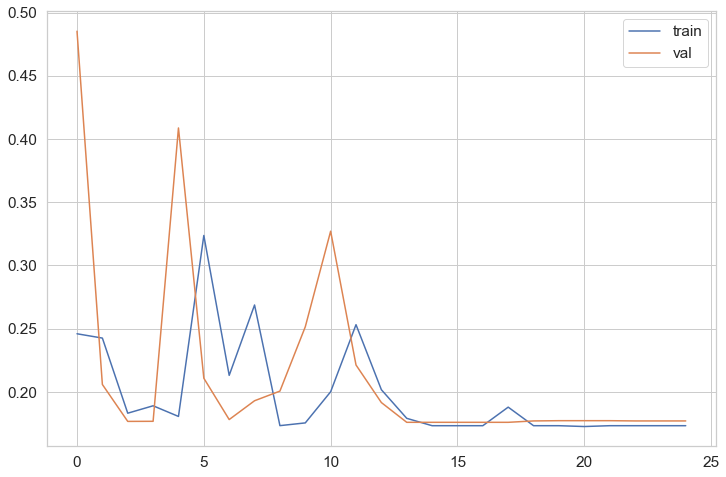

In [26]:
#график лосса при обучении и валидации
sns.set(style='whitegrid', font_scale=1.4)
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label='train')
plt.plot(losses['val'], label='val')
plt.legend()
plt.show()

In [27]:
torch.save(model.state_dict(), 'AlexNet_fine_tune.pth')

In [28]:
model.load_state_dict(torch.load('AlexNet_fine_tune.pth'))

<All keys matched successfully>

In [29]:
print('Accuracy: {0:.4f}'.format(evaluate(model)))

Accuracy: 0.4575


# Feature extractor

In [33]:
model_extractor = models.alexnet(pretrained=True)

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [35]:
for param in model_extractor.parameters():
    print(param.requires_grad)
    #видно что обучаем все слои

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [36]:
#замораживаем веса
for param in model_extractor.parameters():
    param.requires_grad = False
    
num_features = 9216
model_extractor.classifier = nn.Linear(num_features, 2) #заменяем полносвзяный слой на классификатор
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_extractor.classifier.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [37]:
%%time
model_extractor, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

Training complete in 3m 40s
Best val Acc: 0.431373
Wall time: 3min 39s


In [47]:
torch.save(model_extractor.state_dict(), 'AlexNet_extractor.pth')

In [48]:
model_extractor.load_state_dict(torch.load('AlexNet_extractor.pth'))

<All keys matched successfully>

In [49]:
print('Accuracy: {0:.4f}'.format(evaluate(model_extractor)))

Accuracy: 0.4314


# Смешанный способ
### Замораживаем несколько первых слоев

In [42]:
model_mixed = models.alexnet(pretrained=True)

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
layers_to_unfreeze = 5
for param in model_mixed.features[:-layers_to_unfreeze].parameters():
    param.requirs_grad = False

num_features = 9216
model_mixed.classifier = nn.Linear(num_features, 2)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(model_mixed.features.parameters())[-layers_to_unfreeze:] +
                       list(model_mixed.classifier.parameters()),lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [44]:
%%time
model_mixed, losses = train_model(model_mixed, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

Training complete in 6m 4s
Best val Acc: 0.470588
Wall time: 6min 4s


In [50]:
torch.save(model_mixed.state_dict(), 'AlexNet_mixed.pth')

In [51]:
model_mixed.load_state_dict(torch.load('AlexNet_mixed.pth'))

<All keys matched successfully>

In [52]:
print('Accuracy: {0:.4f}'.format(evaluate(model_mixed)))

Accuracy: 0.4706


# Разные lr на разных слоях

In [53]:
model_diff_lr = models.alexnet(pretrained=True)

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [55]:
model_diff_lr.classifier = nn.Linear(num_features, 2)
optimizer = torch.optim.Adam([
        {'params': model_diff_lr.classifier.parameters()},
        {'params': model_diff_lr.features.parameters(), 'lr': 1e-5}
    ], 
    lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [56]:
model_diff_lr, losses = train_model(model_diff_lr, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

Training complete in 6m 3s
Best val Acc: 0.686275


In [57]:
print('Accuracy: {0:.4f}'.format(evaluate(model_diff_lr)))

Accuracy: 0.6209


# VGG16

In [58]:
model_extractor = models.vgg16(pretrained=True)

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\User/.cache\torch\hub\checkpoints\vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [59]:
for param in model_extractor.parameters():
    param.requires_grad = False
    
num_features = 25088
model_extractor.classifier = nn.Linear(num_features, 2) #заменяем полносвзяный слой на классификатор
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_extractor.classifier.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [60]:
model_extractor, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

Training complete in 39m 11s
Best val Acc: 0.954248


# Inception v_3

In [61]:
#меняем размеры, т.к. сеть обучалась на размерах 299
data_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transforms[x])
                for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}

In [64]:
model_extractor = models.inception_v3(pretrained=True)

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\User/.cache\torch\hub\checkpoints\inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [68]:
for param in model_extractor.parameters():
    param.requires_grad = False
    
num_features = 25088
model_extractor.classifier = nn.Linear(num_features, 2) #заменяем полносвзяный слой на классификатор
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_extractor.classifier.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [72]:
model_extractor.AuxLogits.fc = nn.Linear(768, 2)
model_extractor.fc = nn.Linear(2048, 2)

In [73]:
%%time
model_extractor.aux_logits = False
model_extractor, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

Training complete in 22m 57s
Best val Acc: 0.562092
Wall time: 22min 56s


# Efficient Net

In [74]:
!pip install efficientnet_pytorch

You should consider upgrading via the 'C:\Users\User\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.



  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=6980a5f5ffb06c7f3e23f37f508b475d0aeca791c96e01ded589c2166b54d0de
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\29\16\24\752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
Successfully built efficientnet_pytorch


In [78]:
from efficientnet_pytorch import EfficientNet
model_eff = EfficientNet.from_pretrained('efficientnet-b2')

Loaded pretrained weights for efficientnet-b2


In [79]:
model_eff

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    